## Problem 3

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as smo
import patsy as pt
import statsmodels.stats.api as sms
from simple_colors import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import truncnorm
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, KFold

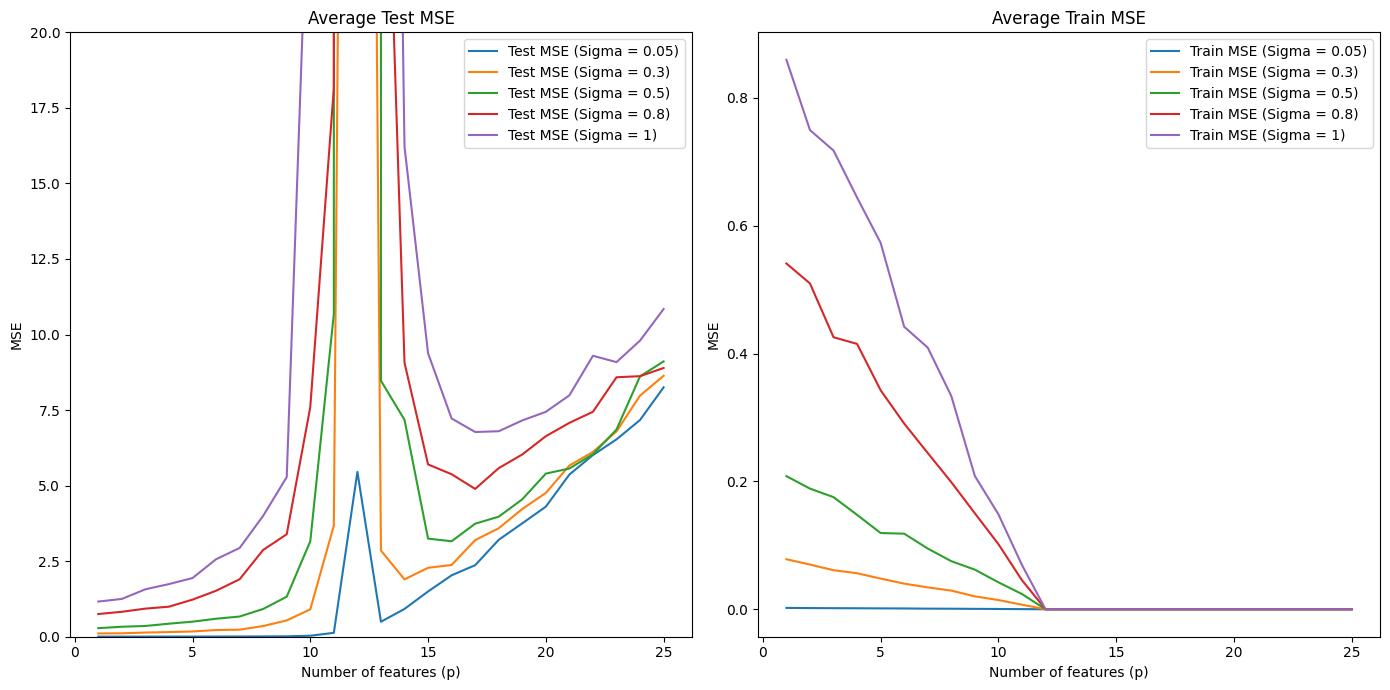

In [56]:
# Parameters Setting
n = 20
max_p = 25
sigmas = [0.05, 0.3, 0.5, 0.8, 1]
num_simulations = 200
np.random.seed(425)

# Initialize arrays to store MSEs
train_mse = np.zeros((len(sigmas), max_p))
test_mse = np.zeros((len(sigmas), max_p))

# Beta coefficients
beta = np.array([0.5 + (0.5 * j / 25) for j in range(1, max_p + 1)])

# Run simulations
for sigma_idx, sigma in enumerate(sigmas):
    for p in range(1, max_p + 1):
        temp_train_mse = []
        temp_test_mse = []
        
        for _ in range(num_simulations):
            # Generate normal random numbers for x
            mean, std = 0, 1  # Mean and standard deviation for the normal distribution
            x = np.random.normal(mean, std, size=(n, p))
            
            # Generate y using a polynomial structure (powers of x) up to degree p
            epsilon = np.random.normal(0, sigma, n)
            y = np.dot(x, beta[:p]) + epsilon
            
            # Split into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=425)
            
            # Train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # Predict and calculate MSE
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            temp_train_mse.append(mean_squared_error(y_train, y_train_pred))
            temp_test_mse.append(mean_squared_error(y_test, y_test_pred))
        
        # Store average MSE over all simulations
        train_mse[sigma_idx, p - 1] = np.mean(temp_train_mse)
        test_mse[sigma_idx, p - 1] = np.mean(temp_test_mse)

# Plotting Test MSE and Train MSE in side-by-side subplots for each sigma
plt.figure(figsize=(14, 7))

for sigma_idx, sigma in enumerate(sigmas):
    # Test MSE plot for each sigma
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_p + 1), test_mse[sigma_idx], label=f'Test MSE (Sigma = {sigma})')
    
    # Train MSE plot for each sigma
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_p + 1), train_mse[sigma_idx], label=f'Train MSE (Sigma = {sigma})')

# Configuring Test MSE plot
plt.subplot(1, 2, 1)
plt.ylim(0, 20)
plt.title('Average Test MSE')
plt.xlabel('Number of features (p)')
plt.ylabel('MSE')
plt.legend()

# Configuring Train MSE plot
plt.subplot(1, 2, 2)
plt.title('Average Train MSE')
plt.xlabel('Number of features (p)')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [57]:
# Find optimal p for each sigma
optimal_p_per_sigma = []

for sigma_idx, sigma in enumerate(sigmas):
    # Find the index of the minimum test MSE for this sigma
    optimal_p_idx = np.argmin(test_mse[sigma_idx])
    optimal_p = optimal_p_idx + 1  # adding 1 because index is 0-based but p starts from 1
    optimal_p_per_sigma.append((sigma, optimal_p))

# Print optimal p for each sigma
for sigma, optimal_p in optimal_p_per_sigma:
    print(f"Optimal p for sigma={sigma}: {optimal_p}")


Optimal p for sigma=0.05: 1
Optimal p for sigma=0.3: 1
Optimal p for sigma=0.5: 1
Optimal p for sigma=0.8: 1
Optimal p for sigma=1: 1


#### From the graphs, I observed abnormal relationships between the test MSE and the train MSE. 
#### The test MSE increased when p increased in all sigma cases while the train MSE decreased as normal. 
#### A U-shape curve was not observed in this cases. This might be because of the limited number of sample sizes compared to the complexity of the polinomial structure models. This might cause overfitting problem since when p>1. 
#### Consequently, Optimal p is p=1 in each senario.

## problem 4

### 4(a)

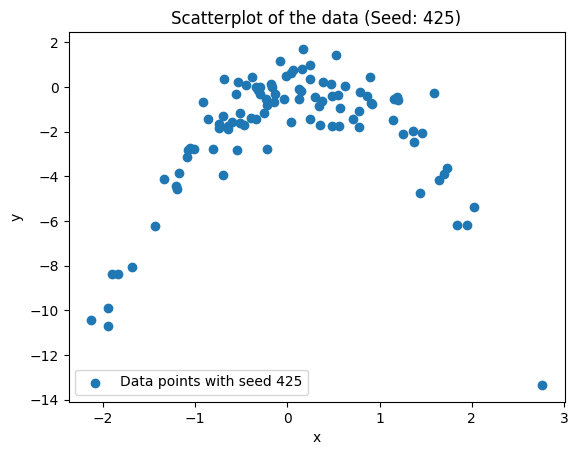

LOOCV: [8.172632025603123, 0.9788264253208808, 1.0326834284516382, 0.9781458582806863]


In [28]:
# Function to generate data
def generate_data(seed):
    np.random.seed(seed)
    x = np.random.normal(0, 1, 100)
    err = np.random.normal(0, 1, 100)
    y = x - 2 * x**2 + err
    return x, y

# Function to compute LOOCV errors and fit models
def analyze_models(x, y):
    models_x = [
        np.column_stack([np.ones(len(x)), x]), #Model1
        np.column_stack([np.ones(len(x)), x, x**2]), #Model2
        np.column_stack([np.ones(len(x)), x, x**2, x**3]), #Model3
        np.column_stack([np.ones(len(x)), x, x**2, x**3, x**4]) #Model4
    ]
    
    loocv = []
    for X in models_x:
        model = LinearRegression()
        scores = -cross_val_score(model, X, y, cv=KFold(n_splits=len(y), shuffle=False), scoring='neg_mean_squared_error')
        loocv.append(scores.mean())
    return loocv

# Set random seed and generate data
seed = 425
x, y = generate_data(seed)

# Scatter plot of the data
plt.scatter(x, y, label=f'Data points with seed {seed}')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Scatterplot of the data (Seed: {seed})')
plt.legend()
plt.show()

# Compute LOOCV errors
loocv = analyze_models(x, y)
print("LOOCV:", loocv)


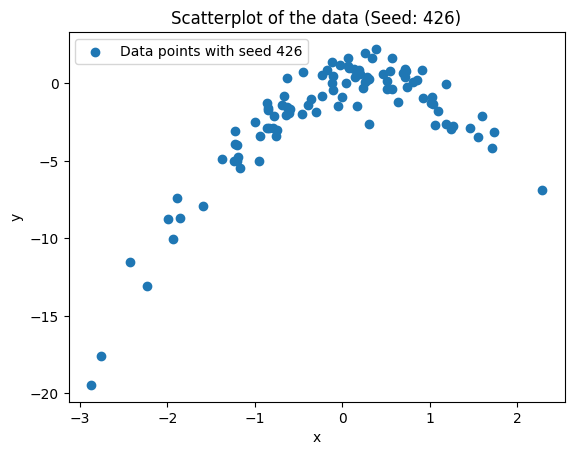

LOOCV seed426: [9.230070973740263, 1.0708495094568935, 1.103383567954704, 1.1608140067169992]


In [29]:
# Set a new random seed and generate data
new_seed = 426
x_new, y_new = generate_data(new_seed)

# Scatter plot of the data with the new seed
plt.scatter(x_new, y_new, label=f'Data points with seed {new_seed}')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Scatterplot of the data (Seed: {new_seed})')
plt.legend()
plt.show()


# Compute LOOCV errors for the new seed
loocv_new = analyze_models(x_new, y_new)
print("LOOCV seed426:", loocv_new)


### 4(b)
The LOOCV results from the rendom seed 426 are different from the results from the random seed 425 in question 4(a) as expected since they were generated from different random seeds. The best model in question 4(a) is Model4 while Model2 is the best model for question4(b). This is because those models gave the lowest LOOCV error for each data set.

### 4(c)
Model4 has the smallest LOOCV error for question 4(a). I did not expect this answer. The true relationship is in the quadratic formula as y was generated, hence, I previously expected Model2 to be the best model and had the smallest LOCCV error. However, I believe that the power of 2 and 4 models have some similar characteristics so they can be substituted for each other like in this case.


In [32]:
# Function to fit models and get statistical summaries
def fit_and_summarize_models(x, y):
    models_x = [
        np.column_stack([np.ones(len(x)), x]),
        np.column_stack([np.ones(len(x)), x, x**2]),
        np.column_stack([np.ones(len(x)), x, x**2, x**3]),
        np.column_stack([np.ones(len(x)), x, x**2, x**3, x**4])
    ]
    
    model_stats = []
    for X in models_x:
        model = sm.OLS(y, X).fit()
        model_stats.append(model.summary())
    return model_stats

model_stats = fit_and_summarize_models(x, y)

# Print model summaries
for i, summary in enumerate(model_stats):
    print(f"Model {i+1} summary:")
    print(summary)
    print("\n\n")


Model 1 summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.997
Date:                Thu, 18 Jan 2024   Prob (F-statistic):             0.0484
Time:                        13:15:46   Log-Likelihood:                -242.03
No. Observations:                 100   AIC:                             488.1
Df Residuals:                      98   BIC:                             493.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9658      0.275   

### 4(d)
From least squares, I can conclude that Model2 is the best model for data in question 4(a) since it has the lowest AIC and BIC among the 4 models. slightly better than Model3 and Model4. Moreover, taking a closer look at Model3 and Model4 estimators, I found that estimators for X^(3) and X^(4) were non-significant. This aligns with my conclusion in question 4(c) that the best model should be Model2 as the true relationship is from quadratic form, but in some cases, Model4 can substitute Model2. This is why the LOOCV error suggested Model4 while the least square suggested Model2.